In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

    
def update(X, Y, model, optimizer): # 学習ステップ
    with tf.GradientTape() as tape:
        Y_pred = model(X) 
        loss_value = L(Y, Y_pred) 
    grads = tape.gradient(loss_value, model.trainable_variables) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value
    
def return_tf_batch(X, Y, batch_size): # バッチ処理
    X_32bits, Y_32bits = X.astype(np.float32), Y.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((X_32bits, Y_32bits))
    dataset = dataset.shuffle(len(X), reshuffle_each_iteration=False) 
    return dataset.batch(batch_size=batch_size).as_numpy_iterator()

class MyModel(tf.keras.Model): # モデル設計
    def __init__(self, H=10, N_L=3, BN=False):
        self.N_L = N_L
        self.BN = BN
        super(MyModel, self).__init__()
        self.Layers = []
        self.BNs = []
        for i in range(N_L):
            self.Layers.append(tf.keras.layers.Dense(units=H))
            self.BNs.append(tf.keras.layers.BatchNormalization())
        self.Layers.append(tf.keras.layers.Dense(units=3))
        
    def call(self, x):
        h = self.h(self.N_L, x)
        h = tf.keras.activations.softmax(self.Layers[-1](h))
        return h
    
    def h(self, N_L, x):
        h = x
        for i in range(N_L):
            h = self.Layers[i](h)
            if self.BN:
                h = self.BNs[i](h)
            h = tf.keras.activations.relu(h)
            
        return h
    
class CNNModel(tf.keras.Model): # モデル設計
    def __init__(self, BN=False):
        super(CNNModel, self).__init__()
        self.c1 = tf.keras.layers.Conv2D(32, (3,3))
        self.c2 = tf.keras.layers.Conv2D(64, (3,3))
        self.c3 = tf.keras.layers.Conv2D(64, (3,3))
        self.f = tf.keras.layers.Flatten()
        self.l1 = tf.keras.layers.Dense(64)
        self.l2 = tf.keras.layers.Dense(10)
        self.BN = BN
        if BN:
            self.bn1 = tf.keras.layers.BatchNormalization()
            self.bn2 = tf.keras.layers.BatchNormalization()
            self.bn3 = tf.keras.layers.BatchNormalization()
            self.bn4 = tf.keras.layers.BatchNormalization()
            self.bn5 = tf.keras.layers.BatchNormalization()
            
    def call(self, x):
        if self.BN:
            h = tf.keras.activations.relu(self.bn1(self.c1(x)))
            h = tf.keras.activations.relu(self.bn2(self.c2(h)))
            h = tf.keras.activations.relu(self.bn3(self.c3(h)))
            h = self.f(h)
            h = tf.keras.activations.relu(self.bn4(self.l1(h)))
            h = tf.keras.activations.softmax(self.bn5(self.l2(h)))
            return h
        else:
            h = tf.keras.activations.relu(self.c1(x))
            h = tf.keras.activations.relu(self.c2(h))
            h = tf.keras.activations.relu(self.c3(h))
            h = self.f(h)
            h = tf.keras.activations.relu(self.l1(h))
            h = tf.keras.activations.softmax(self.l2(h))
            return h
        
    def summary(self):
        ''' This implementation is derived from an answer from Stack Overflow.
            URL is:
            * https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model 
              - questioner: Gary (https://stackoverflow.com/users/8101774/gary)
              - answerer: Gary (https://stackoverflow.com/users/8101774/gary)
            
            This comment is written following by 
            * https://stackoverflow.blog/2009/06/25/attribution-required/
            
            License on Code snoppets on Stack Overflow is explained below:
            * https://stackoverflow.com/legal/terms-of-service/public#licensing
        '''
        x = tf.keras.Input(shape=(32, 32, 3))
        return (tf.keras.Model(inputs=[x], outputs=self.call(x))).summary()

## 5-1. バッチ正規化

再びアヤメデータを用いて深層学習させてみましょう。



In [4]:
iris = load_iris() # アヤメデータ読み込み
X_train, Y_train = iris.data, iris.target
L = tf.keras.losses.SparseCategoricalCrossentropy() # 誤差関数

今回は

$$
\mathbb{R}^4 \underbrace{\to (\mathbb{R}^H, \text{relu}) \to (\mathbb{R}^H , \text{relu}) \to \cdots \to (\mathbb{R}^H , \text{relu})}_{N_L \text{times}} \to (\mathbb{R}^3, \text{softmax}) \to [0,1]^3
$$

のようなネットワークを作って、色々な設定で実験できるようにしておきました。

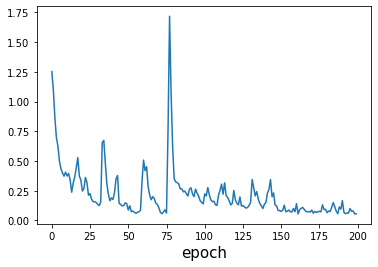

CPU times: user 12.8 s, sys: 459 ms, total: 13.2 s
Wall time: 12 s


In [11]:
%%time
epoch_size=200

tf_update = tf.function(update)
model = MyModel(H=10, N_L=6)
optimizer=tf.keras.optimizers.Adam(lr=0.1)

loss_averages = []
h_covariates = []
for epoch in range(epoch_size):
    batch = return_tf_batch(X_train, Y_train, batch_size=32)
    loss_values = []
    for (x,y) in batch:
        covariates = []
        for i in range(model.N_L):
            h = model.h(i, x)
            covariates.append(np.mean(model.h(i, x)))
        h_covariates.append(covariates)
        loss_value = tf_update(x, y, model, optimizer)
        loss_values.append(loss_value)
    loss_averages.append(np.average(loss_values))
    
h_covariates = np.array(h_covariates); plt.xlabel("epoch", fontsize=15)
plt.plot(np.arange(epoch_size), loss_averages); plt.show()

わざと無駄に巨大なモデルを作りましたが、10層もあれば本格的な深層学習のダイナミクスに近いでしょう。ここで、各SGDステップ毎のネットワーク

$$
{\bf x} \to {\bf h}_1 \to {\bf h}_2 \to \dots \to {\bf h}_{N_H-1} \to {\bf y}
$$

の統計量（サンプル平均）をプロットしてみましょう。ここでは簡単のため、${\bf H} = [{\bf h}^{(1)}, {\bf h}^{(2)}, \dots, {\bf h}^{(\text{batch size})}]$ の平均値のプロットを取っています：

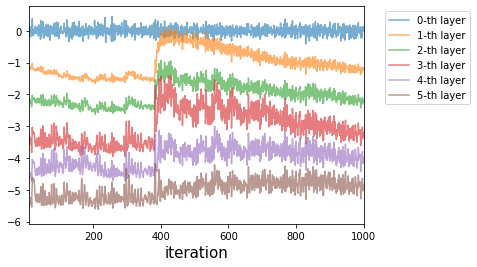

In [12]:
plt.xlim(10,1000); plt.xlabel("iteration", fontsize=15)
for i in range(model.N_L):
    y = h_covariates[:,i]
    y -= np.mean(y)
    y -= i
    plt.plot(np.arange(len(h_covariates)), y, alpha=.6, label='{}-th layer'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.show()

縦軸はわかりやすいように正規化して、層ごとに順番に並べました。まず `0-th layer` とあるのは入力値 ${\bf x}$ の平均の統計です。入力ベクトルはデータから取っているので、常に同じ統計を示します。次に`1-st layer` を見てみると、初めの方で値のシフトが起こっています。これは1層目まで誤差が伝搬したため、訓練がスタートしたことを示します。その後も順にパラメータ更新が起こっているのが確認できますが、
* それぞれの層の出力値は訓練が進むと暴れだすような気

がします。これを緩和する手法に**バッチ正規化(batch-normalization, BN)** というものがあります。これはtensorflowではLayerオブジェクトとして扱って
```
tf.keras.layers.BatchNormalization()
```

として呼び出すことができます。


![alt](net.jpg)

毎回の非線形関数の呼び出し前に、このBN層を挿入した訓練をしてみます：

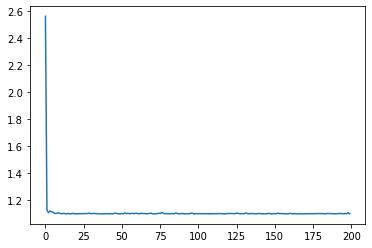

CPU times: user 21.7 s, sys: 715 ms, total: 22.4 s
Wall time: 20.3 s


In [13]:
%%time
epoch_size=200

tf_update = tf.function(update)
model = MyModel(H=10, N_L=6, BN=True)
optimizer=tf.keras.optimizers.Adam(lr=0.1)

loss_averages = []
h_covariates = []
for epoch in range(epoch_size):
    batch = return_tf_batch(X_train, Y_train, batch_size=32)
    loss_values = []
    for (x,y) in batch:
        covariates = []
        for i in range(model.N_L):
            covariates.append(np.mean(model.h(i, x)))
        h_covariates.append(covariates)
        loss_value = tf_update(x, y, model, optimizer)
        loss_values.append(loss_value)
    loss_averages.append(np.average(loss_values))
    
h_covariates = np.array(h_covariates)
plt.plot(np.arange(epoch_size), loss_averages); plt.show()

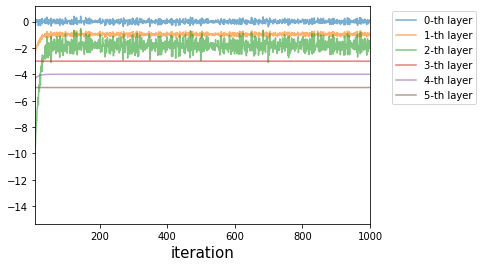

In [14]:
plt.xlim(10,1000); plt.xlabel("iteration", fontsize=15)
for i in range(model.N_L):
    y = h_covariates[:,i]
    y -= np.mean(y)
    y -= i
    plt.plot(np.arange(len(h_covariates)), y, alpha=.6, label='{}-th layer'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.show()

このように、各層の出力値が暴れるのを抑える効果があります。

### Understanding BN step by step
バッチ正規化は [arXiv:1502.03167](https://arxiv.org/abs/1502.03167) で導入されて以来、深層ニューラルネットの訓練を安定化、高速化する手法として現在では広く認識されています。ここではバッチ正規化が背後で何をやっているのか説明します。

#### 1. (訓練中)特徴量の偏りを補正する
まず、バッチ正則化を入れる前のネットワークでミニバッチ $B$ が入ってきたときのことを想像してみましょう。極端な例ですが、ネットワークにバイアスがあると、以下の図のように、中間での表現に偏りが生じるかもしれません：

![alt](net2.jpg)

ここで、2次元の図は本当は中間ベクトル ${\bf h}^l$ の次元での図がかければよいのですが、ここでは説明のため二次元化しています。このような偏りを解消するには、${\bf h}^l_i = [(h^l_i)_1, (h^l_i)_2, \dots (h^l_i)_{\dim h}] $ のようなベクトルの成分表示で、正規化

$$
(\hat{h} \ ^l_i)_\alpha =\frac{(h^l_i)_\alpha - (\mu_B)_\alpha }{(\sigma_B)_\alpha}
$$

のようにするといいでしょう。ここで平均 $(\mu_B)_\alpha = \frac{1}{|B|}\sum_{i=1}^{|B|} (h^l_i)_\alpha$、分散$^※$ $(\sigma_B)_\alpha = \sqrt{\frac{1}{|B|} \sum_{i=1}^{|B|}((h^l_i)_\alpha - \mu_\alpha)^2}$ です。

> $^※$少なくとも原論文では、分散は不偏分散を用いない定義のようです。後述する運用時には不偏分散に戻します。また、ここでの正規化は分散が小さすぎる場合にオーバーフローを起こしかねないので、適当に小さな値を足した $\sigma_\alpha \to \sigma_\alpha + \epsilon$ が使われます。

イメージ図を描くと以下のようになります：

![alt](net3.jpg)

こうしておくと、中間表現が過度に偏ったり、暴れるのを制御できるわけです。

#### 2. (訓練中)モーメントを回復させる
しかし、これだと特徴量を3次のモーメントからしか表現できません。これを避けるために、正規化で無くした1,2次モーメントを **学習パラメータ** として復活させるのが BN のポイントです。ベクトルの成分 $\alpha$ ごとに訓練可能なパラメータ${\color{red}{\gamma_\alpha, \beta_\alpha}}$ を導入し、成分ごとの積と和を出力とします：

$$
\text{BN}_{\color{red}{\gamma, \beta}}({\bf h}^l_i) = {\color{red}{\bf \gamma}}\ \odot \hat{{\bf h}}\ _i^l + {\color{red}{\bf \beta}}
$$

![alt](BN1.jpg)

ネットワークの訓練で、これまでのニューラルネットワークに含まれていた線形変換のパラメータに加え、 ${\color{red}{\gamma_\alpha, \beta_\alpha}}$ もSGDで更新していくことになります。これで大体のバッチ正規化層の処理は説明できたのですが、**訓練が終わった後にどうなるか** 考えてみると、おかしなことが起こる場合があることに気が付きます。というのは、訓練後は**たった1つのデータ ${\bf x}$ の入力に対する出力を見たい場合がある** わけですが、この場合、正規化の部分で同じことをやると、$\mu = {\bf h}^l, \sigma = 0$になってしまい、意味のない処理になってしまいます。訓練後も1つのデータではなく、多数のデータを入れることにすればこの問題は無いですが、通常は以下のように対処します。

#### モーメントの保存
SGDでは元のデータが適当なミニバッチ系列

$$
B_1, B_2, \dots, B_{\#\text{iters}}
$$

に適当に組み直されて、順に勾配更新していくのでした。更新が安定してくれば、訓練での（つまり上の系列で）後半の方の統計量は安定してくるはずです。そこで、各ミニバッチ $B_I$ における統計量 $\mu_{B_I}, \sigma_{B_I}$ を**保存しておきます**。

#### 3. (訓練後)のBNの運用法
SGD訓練で保存した統計量$^※$をもちいて

$$
\mu = \frac{1}{\#\text{iters}} \sum_{I=1}^{\#\text{iters}} \mu_{B_I}, \quad
\sigma^2 = \frac{\#\text{iters}}{\#\text{iters}-1}\sum_{I=1}^{\#\text{iters}} \sigma^2_{B_I}
$$

とします。

> $^※$ ただし、深層学習では#itersが非常に大きいので、統計量を全て記録しておくとメモリを圧迫するので、おそらく再帰的な定義で内部の統計量$\mu, \sigma^2$ も更新されているのだと思います…たぶん。ちゃんと実装の詳しいところまで把握していないので予想ですが。

この $\mu, \sigma$ を使えば、訓練後にサイズ1の入力にも使えるばかりか、大数の法則により、対象となるドメインの特徴量の統計もうまく表現する量になることが期待されます：

![alt](BN2.jpg)




このようにBNは訓練時と運用時で処理が微妙に異なるので注意が必要です。tensorflowでこの振る舞いをオンオフするには、[BNのAPIドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)によると、`BN = tf.keras.layers.BatchNormalization()`として作ったBN層のオブジェクトを呼ぶ際に
* `BN(h, training=True)`とするとミニバッチ方向の統計で計算した$\mu_B, \sigma_B$
* `BN(h, training=False)`とするとそれまでに溜まった統計で計算した$\mu, \sigma$

が使用されるようです。

In [15]:
model.BNs[5].gamma # これは一旦バッチを放り込むなどしてサイズを確定させないとNone?

<tf.Variable 'my_model_4/batch_normalization_29/gamma:0' shape=(10,) dtype=float32, numpy=
array([0.40211925, 0.5322809 , 0.54692096, 0.25416112, 0.54874927,
       0.46576574, 1.5991176 , 0.47892985, 0.4667284 , 0.39969146],
      dtype=float32)>

### 畳み込み演算に対するBN
ここまで全結合型のニューラルネットワークに対するBNを説明してきましたが、畳込み層では畳み込みの構造を考慮した、より簡素化されたBN処理が使われます。具体的に言うと、入力を $i,j$:x,y方向のピクセル座標、$c$:チャネル

$$
h_{\alpha \beta}^c : (\alpha= 0,1, \dots, L_x - 1), (\beta= 0,1, \dots, L_y - 1), (c=0,1, \dots, L_c-1)
$$

としたとき、正規化のための平均をミニバッチ方向**だけではなくxy方向にも取る** ということをします：

$$
\mu_B^c = \frac{1}{|B|} \sum_{I=1}^{|B|} \frac{1}{L_x L_y} \sum_{\alpha=0}^{L_x-1}\sum_{\beta=0}^{L_y-1} (h_I)_{\alpha \beta}^c,
\quad 
(\sigma_B^c)^2 = \frac{1}{|B|} \sum_{I=1}^{|B|} \frac{1}{L_x L_y} \sum_{\alpha=0}^{L_x-1}\sum_{\beta=0}^{L_y-1} \Big( (h_I)_{\alpha \beta}^c  - \mu_B^c \Big)^2
$$

これで正規化した後、やはり訓練可能なパラメータ ${\color{red}{\gamma^c, \beta^c}}$ をチャネル毎に導入し、

$$
\text{BN}_{\color{red}{\gamma, \beta}}(h_{\alpha \beta}^c) = {\color{red}{\gamma^c}} \frac{h_{\alpha \beta}^c - \mu_B^c}{\sigma_B^c}  + {\color{red}{\beta^c}} 
$$

のように処理します。
> 繰り返しになりますが、分母はオーバーフロー対策のため実装では $\sigma_B^c \to \sqrt{(\sigma_B^c)^2 + \epsilon}$ と置き換えたものが使われます。

要はチャネル毎にベクトル扱いして、通常のBNを行うということです。図示すると以下のようになります：

![alt](BN3.jpg)

運用時には保存しておいた $\mu_B^c, \sigma_B^c$ の平均を使うのも同じです。

#### 畳み込みニューラルネットBNある無し比較
前にMNIST分類器を畳み込みニューラルネットで作りました。そのときのネットワークの、
* `(Conv2D)`
* `(Dense)`

の直後にBNを挿入しない/挿入したときの違いを見てみることにしましょう。具体的には以下で作れます：

In [16]:
model = CNNModel(BN=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 30, 30, 32)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_31 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
tf_op_layer_Relu_1 (TensorFl [(None, 28, 28, 64)]      0     

BN層のパラメータ数に注意してください。例えば最初のBNは
* `Output Shape = (None, 30, 30, 32)`, `Params # = 128`

となっており、直前の畳込み演算で受け取ったテンソルの次元を変えていない事がわかります。また、パラメータ数が$\gamma, \beta$のチャネル数分の64ではなく、その倍の128になっているのは恐らく $\mu, \sigma$ を動的更新するために更に64個の変数を内包しているからだと思われます。

ちなみにMNISTデータで事前にやってみたところ、データのサイズ感が小さすぎたためか、BNが無くても十分安定した訓練が可能なため、BNを導入してもさほどの差はありませんでした。そこでここでは全く同じネットワークを **CIFAR-10**(3色RGBカラー32x32画像) で訓練してみます。

In [5]:
cifar10 = tf.keras.datasets.cifar10 
(X, Y), (X_test, Y_test) = cifar10.load_data()

train_images = X/255.0; test_images = X_test/255
train_labels = Y; test_labels = Y_test

CIFAR-10をダウンロードしていない場合、ダウンロードされます。既にダウンロードしている場合はそのままです。この元で、`.fit` で検証もしながらBN無しと有りで訓練してみましょう。

In [5]:
%%time
model = CNNModel(BN=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, verbose=0, epochs=10, batch_size=64, 
                    validation_data=(test_images, test_labels)).history

model = CNNModel(BN=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_BN = model.fit(train_images, train_labels, verbose=0, epochs=10, batch_size=64, 
                       validation_data=(test_images, test_labels)).history             

CPU times: user 1min 18s, sys: 10.1 s, total: 1min 28s
Wall time: 2min 27s


GPUで1~2分かかります。CPUではちょっと厳しいかもしれないです。ともかく訓練が終われば以下で
* 訓練データについての softmaxエントロピーloss, 正答率
* 検証データについての softmaxエントロピーloss, 正答率

をプロットすることができます：

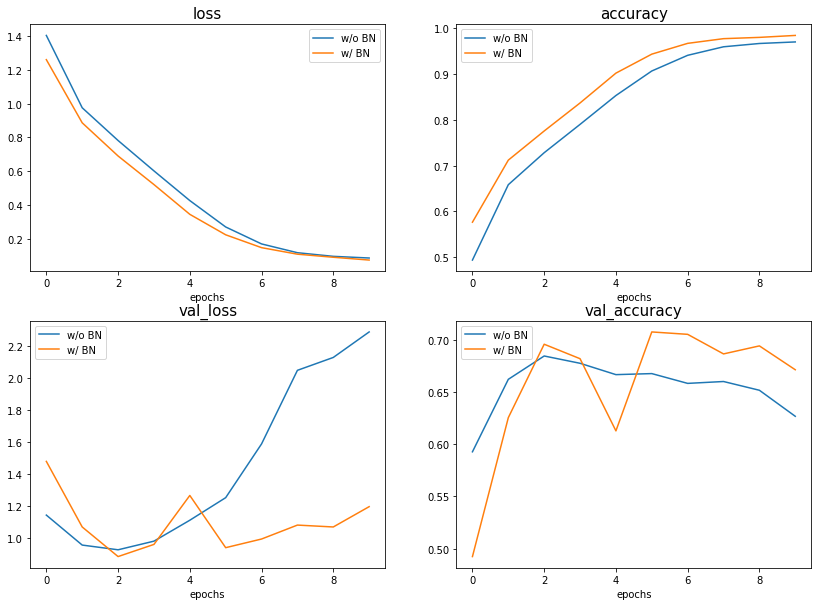

In [12]:
fig = plt.figure(figsize=(14,10))
ax11 = fig.add_subplot(2,2,1); ax12 = fig.add_subplot(2,2,2)
ax21 = fig.add_subplot(2,2,3); ax22 = fig.add_subplot(2,2,4)
vs = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
for i in range(4):
    fig.axes[i].set_title(vs[i], fontsize=15)
    fig.axes[i].set_xlabel('epochs')
    fig.axes[i].plot(np.arange(10), history[vs[i]], label='w/o BN')
    fig.axes[i].plot(np.arange(10), history_BN[vs[i]], label='w/ BN')
    fig.axes[i].legend()

BNが訓練データ/検証用データの両方に良い影響を与えているのがわかります。訓練したネットワークを使う際は説明したように、**訓練後のモードで使うべき** ですが、ここで訓練したモデルは
* `model.predict(x)`
* `model(x, training=False)`
* `model(x)`

のどのコマンドでも正常に動作するようです。ただし
* `model(x, training=True)`

とすると、訓練中と見なされて、（おそらく運用バッチの統計を取ってしまい）意図しない動作をしました：

answer=[1]
model.predict(x_in) -> 1
model(x_in, training=False) -> 1
model(x_in) -> 1
model(x_in, training=True) -> 3


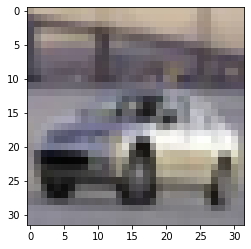

In [ ]:
i = np.random.randint(10000)
plt.imshow(test_images[i])
print("answer={}".format(Y_test[i]))
x_in = test_images[i].reshape(1,32,32,3).astype(np.float32)
print("model.predict(x_in) -> {}".format(np.argmax(model.predict(x_in))))
print("model(x_in, training=False) -> {}".format(np.argmax(model(x_in, training=False))))
print("model(x_in) -> {}".format(np.argmax(model(x_in))))
print("model(x_in, training=True) -> {}".format(np.argmax(model(x_in, training=True))))

### なぜバッチ正規化か？
もともとの [arXiv:1502.03167](https://arxiv.org/abs/1502.03167) によるバッチ正規化の動機は、**内部共変量シフト(internal covariate shift ,ICS)** と呼ばれる現象を緩和することでした。これは訓練中にネットワークの各層 ${\bf h}^l$ の特徴量分布が変動してしまう現象があるだろうと思われており、それを正規化で緩和させるという狙いであり、バッチ正規化がうまく働く事もあってこのICSを緩和するというシナリオは広く受け入れられていました。

しかし、この節の初めに実験してみたように、もしISCが訓練を妨げているというのであれば、1層目でICSが起こり、それが2層目に伝わり…という風にして、各層の ${\bf h}^l$ の統計量がずれだすタイミングは、異なるはずです。今回のノートを準備するにあたってそのようになると期待してコーディングしましたが、統計量が暴れだすタイミングはだいたいどの層も同じであることが多く、ICSの緩和で訓練が進みやすくなるというシナリオはどうも怪しい気がしました。

そこで調べてみたところ、実際にBNが上手く動作するのはICSの軽減のおかげ**ではない**という論文 [arXiv:1805.11604](https://arxiv.org/abs/1805.11604) を見つけました。この論文では、**BN層の直後にランダムノイズによる摂動を加え**たネットワークで訓練する実験を行っています。このノイズ摂動は**ICSを人工的に作り出す**操作と思えますが、このようなネットワークを用いても**精度が落ちない**ことを確認しています。この論文ではBNの良さは誤差関数のランドスケープをBNが滑らかにする（とくに誤差関数の勾配の大きさがBN無しの場合に比べ小さくなる）こと、更にネットワーク重み $W$ の初期化の段階でBNがあると良い効果をもたらすことを議論しています。

また、別の論文 [arXiv:1806.02375](https://arxiv.org/abs/1806.02375) では、ICSの緩和ではない他の理由（高い学習率を使っても発散が起こらないこと）がBNが良い訓練をもたらす原因と主張していますが、その一方で [arXiv:1902.08129](https://arxiv.org/abs/1902.08129) ではニューラルネットワークの平均場理論を用いることで、全く逆の主張：**BNは勾配爆発を誘発する**としています。ただし、これはスキップ接続があると回避できるとのことです。

このように、BNはICSを軽減する、という名目で導入され、確かに訓練を安定化/向上させることが実際に多くの深層学習実験で確認されたため、現在では広く使われるテクニックの一つになったのですが、結局の所なぜBNが良いのか、そもそも本当に良いのか、などについて理論的なコンセンサスは未だ取れていないのが現状です。

最後に、ニューラルネットの途中に正規化を挟む手法はBN以外にもいくつか提案されているので、気になる人は調べてみてください。

### Comments on the licensed source code used in this subsection

#### Attribution of Class method `summary()`

The implementation of

* Class method: `CNNModel.summary()`

is derived from a post of Stack Overflow. URL is:
- https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model 
    - questioner: Gary (https://stackoverflow.com/users/8101774/gary)
    - answerer: Gary (https://stackoverflow.com/users/8101774/gary)
            
This comment for the attribution is written by following the way explained in
- https://stackoverflow.blog/2009/06/25/attribution-required/
            
License on Code snoppets on Stack Overflow is explained in
- https://stackoverflow.com/legal/terms-of-service/public#licensing